# HW3: Sensing & Coordinate Frames

## EECE 5550: Mobile Robotics (Spring 2024)

**Collaboration Statement:**

In [1]:
# Here, I completed the assignment entirely on my own, but I had a conversation with Rahul Bhowal about Question 1B.

# Installation

This semester, we will use a custom simulator, called `gym-neu-racing`, to develop navigation algorithms. We implemented the basic structure of this simulator for you, and the HW assignments will ask you to implement important functions (e.g., kinematics, sensing, planning, mapping).

To install the simulator, you can use this command (it will download the latest code from GitLab and automatically install it in the environment your Colab notebook runs in):

In [2]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to c:\users\anuj\appdata\local\temp\pip-req-build-cxso5d66
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit 60f6a0e80b5ae6dd14fb13a837c252d0d88fe571
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git 'C:\Users\Anuj\AppData\Local\Temp\pip-req-build-cxso5d66'


Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [3]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
from gym_neu_racing import sensor_models
import cvxpy as cp
from gym_neu_racing.sensor_models.sensor_model import SensorModel

You can create an instance of the simulator that you'll build on throughout the assignment:

# Problem 1: Lidar Sensor Model

## 1a) 2D Lidar Simulation

In previous assignments, we gave you the robot's true state and environment map. However, in many real robotics settings, onboard sensors are the only way to estimate the robot's state and what the environment looks like.
Therefore, in this problem, you'll implement a basic version of a 2D Lidar simulator that we'll use as input to our estimation algorithms on in future assignments.

We will use the idea of *ray tracing* for this sensor model.
A rough sketch for this is: for each beam, check whether the map is free or occupied as you move along the beam away from the robot's current position (if it's free, keep moving further along the range (increment by `self.range_resolution`); if it's occupied, stop there, and you now have the distance to the first occupied cell along that beam). After you've done this for all beams, you can return an array of angles and a corresponding array of ranges - that's the data format used by most Lidar sensors when reporting measurements. Lastly, if there are no obstacles within the maximum range (`range_limits[1]` meters), you should return `np.inf` for that beam, per [ROS REP 117](https://www.ros.org/reps/rep-0117.html).

It may be helpful to implement this sensor model with a few for loops that iterate over each beam and increment range resolution until finding an occupied cell, but this will probably be pretty slow computationally. Instead of nested for loops, you could leverage numpy operations (e.g., `np.where`, `np.cumsum`, `np.logical_and`, `np.meshgrid`, `np.tile`) to efficiently make these calculations over all beams and ranges. You're also of course welcome to try using JAX and its `vmap` operator if you feel inspired...

We also provide a simple plotting function in case that helps you debug your sensor model implementation.

For this model, we'll assume:
* the lidar senses free/occupied space ideally (i.e., zero probability of spurious readings)
* the robot has zero radius (i.e., the sensor will not have any ``self-hits'' where the beam hits a point on the robot and returns a short range)
* the robot's body frame (in which `current_state` and `obs["state"]` are reported) and lidar frame (in which the lidar data is reported) are aligned (i.e., the transformation matrix between these two frames is the identity matrix)

**Deliverables**:
- Implement the `Lidar2D` class, in particular the `step` method, so that the returned `sensor_data` contains the correct `angles` and corresponding `ranges` in the lidar's frame, based on the environment map and the robot's `current_state` (be sure to account for position and orientation of the robot!).
- Print the first `sensor_data` your Lidar2D sensor returns from the `env.reset()` method
- Include a plot that shows the environment map with your first lidar scan overlayed on top

In [4]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEURacing-v0")

In [5]:
class Lidar2D(SensorModel):
    def __init__(
        self,
        static_map,
        num_beams=16,
        range_resolution=0.1,
        range_limits=np.array([0, 6]),
        angle_limits=np.array([-np.pi / 2, np.pi / 2]),
    ):
        super().__init__()
        self.static_map = static_map
        self.num_beams = num_beams
        self.range_resolution = range_resolution
        self.range_limits = range_limits
        self.angle_limits = angle_limits

        self.angles = np.linspace(
            self.angle_limits[0], self.angle_limits[1], self.num_beams
        )

        self.ranges = np.arange(
            self.range_limits[0], self.range_limits[1] + self.range_resolution, self.range_resolution
        )

        self.observation_space = spaces.Dict({
            "angles": spaces.Box(-np.pi, np.pi, shape=(self.num_beams,), dtype=np.float64),
            "ranges": spaces.Box(self.range_limits[0], np.inf, shape=(self.num_beams,), dtype=np.float64),
        })

    def step(self, current_state: np.ndarray) -> dict:
        heading = current_state[2]
        position = current_state[:2]

        angles = self.angles + heading
        angles, ranges_mesh = np.meshgrid(angles, self.ranges)
        angles = angles.flatten()
        ranges_mesh = ranges_mesh.flatten()

        # Calculate endpoint coordinates for all beams and ranges
        x_endpoints = position[0] + ranges_mesh * np.cos(angles)
        y_endpoints = position[1] + ranges_mesh * np.sin(angles)

        # Convert endpoints to map indices
        endpoints = np.vstack((x_endpoints, y_endpoints)).T
        map_indices, valid = self.static_map.world_coordinates_to_map_indices(endpoints)

        # Initialize beam ranges with inf, then update with actual ranges upon obstacle detection
        beam_ranges = np.full(self.num_beams, np.inf)

        # Check each beam for obstacle hits
        for i in range(self.num_beams):
            beam_angle_indices = map_indices[i::self.num_beams]  # Select indices corresponding to each beam
            beam_valid = valid[i::self.num_beams]  # Validity for each point along the beam

            # Find the first obstacle hit along each beam
            for j, (map_index, is_valid) in enumerate(zip(beam_angle_indices, beam_valid)):
                if is_valid and self.static_map.static_map[map_index[0], map_index[1]]:
                    beam_ranges[i] = self.ranges[j % len(self.ranges)]
                    break

        sensor_data = {
            "ranges": beam_ranges,
            "angles": self.angles,
        }

        return sensor_data

In [6]:
def plot_lidar_measurements(static_map, obs: dict) -> None:
    """Transform lidar readings into world frame and overlay on static map."""

    # Use angles/ranges to get the (x, y) coordinates in the lidar frame, but
    # skip any pts where the range = np.inf
    ranges = obs["lidar"]["ranges"]
    non_max_range_inds = np.where(ranges < np.inf)
    ranges = ranges[non_max_range_inds]
    angles = obs["lidar"]["angles"][non_max_range_inds]
    hit_pts_in_lidar_frame = np.stack(
        [ranges * np.cos(angles), ranges * np.sin(angles)]
    ).T

    # Build the lidar-to-world TF matrix using the robot's current position, heading
    x, y, theta = obs["state"]
    T_world_lidar = np.array(
        [
            [np.cos(theta), -np.sin(theta), x],
            [np.sin(theta), np.cos(theta), y],
            [0, 0, 1],
        ]
    )

    # Transform the (x,y) coordinates from the lidar frame to the world frame
    hit_pts_in_lidar_frame_homogeneous = np.hstack(
        [hit_pts_in_lidar_frame, np.ones((hit_pts_in_lidar_frame.shape[0], 1))]
    )
    hit_pts_in_world_frame = np.dot(
        hit_pts_in_lidar_frame_homogeneous, T_world_lidar.T
    )

    # Overlay the lidar pts on top of the static map
    static_map.draw_map(show=False)
    for pt in hit_pts_in_world_frame:
        plt.plot([x, pt[0]], [y, pt[1]], "r-")

    # Draw the robot as a blue triangle to indicate its pose
    robot_pts = np.array([[0.4, 0.0], [0, -0.1], [0, 0.1], [0.4, 0.0]])
    robot_pts_homogeneous = np.hstack(
        [robot_pts, np.ones((robot_pts.shape[0], 1))]
    )
    robot_pts_in_world_frame = np.dot(robot_pts_homogeneous, T_world_lidar.T)
    plt.plot(
        robot_pts_in_world_frame[:, 0], robot_pts_in_world_frame[:, 1], "b-"
    )

    plt.show()

You can use the following code to see what your sensor returns in specific states:

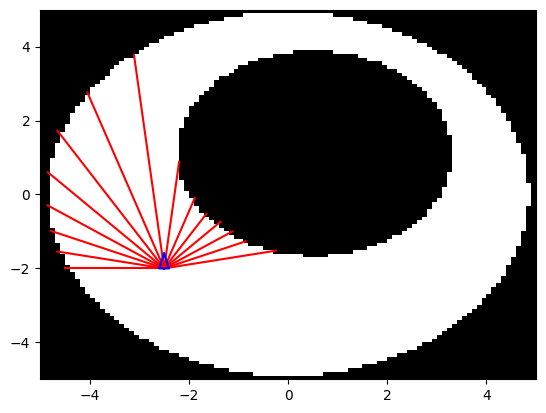

In [7]:
state = np.array([-2.5, -2, np.pi/2])
lidar_measurements = Lidar2D(env.unwrapped.map).step(state)
obs = {"state": state, "lidar": lidar_measurements}
plot_lidar_measurements(env.unwrapped.map, obs)

And for the deliverables, you should confirm your sensor also works as part of the full simulator:

{'state': array([ 0.8392881 , -3.78481063,  3.24435603]), 'lidar': {'ranges': array([2.1, 2.3, 2.8, inf, inf, 6. , 5. , 4. , 3. , 2.3, 1.9, 1.6, 1.3,
       1.2, 1.1, 1.1]), 'angles': array([-1.57079633, -1.36135682, -1.15191731, -0.9424778 , -0.73303829,
       -0.52359878, -0.31415927, -0.10471976,  0.10471976,  0.31415927,
        0.52359878,  0.73303829,  0.9424778 ,  1.15191731,  1.36135682,
        1.57079633])}}


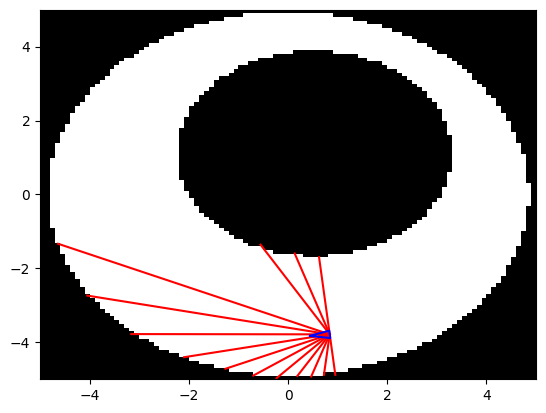

In [8]:
# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(0)

# Tell the environment to use your new Lidar2D sensor
env.unwrapped.sensor_models = {
  "state": sensor_models.StateFeedback(),
  "lidar": Lidar2D(env.unwrapped.map),
}

# Reset the environment and get the first observation (state + lidar)
obs, _ = env.reset()
print(obs)
plot_lidar_measurements(env.unwrapped.map, obs)

## 1b) Adding noise to your ideal 2D lidar model

In the previous part, we assumed that the lidar sensor returns the correct range (whenever there is an occupied cell within a distance less than the maximum range). In reality, lidar sensors are subject to various issues that can degrade the returned range measurements. In this part, you will extend your sensor model to include some of these effects.

In particular, your job is to implement this idea as `Lidar2DRealistic`, using a PDF that accounts for the 4 types of errors described in the following slides [Slide 1](https://northeastern.sharepoint.com/:i:/s/EECE5550Crew/Ef9xNqaeM-xIoyK-Frgp_pgByp1ZX6G2DuDPay9qwOL56g?e=stnmc0) [Slide 2](https://northeastern.sharepoint.com/:i:/s/EECE5550Crew/Ef34lEdH6gtJhq-q61cyLQEBznUrxe32AdlUr5XV5elnYw?e=nfgwfm). The slides use the following notation: $x_t$ is the robot's state at time $t$, $m$ is the map, $z_t^k$ is the $k^\text{th}$ beam's reading at time $t$, $z_t^{k*}$ is the true range that a perfect sensor would have read. Instead of returning the true range $z_t^{k*}$ for each beam $k$, we will treat each beam's reading as an i.i.d. sample from a conditional probability distribution, $P(z_t^k | x_t, m)$.

For example, we provide a simple version of this below, where $z_t^k \sim N(z_t^{k*}, \sigma^2)$.

The specifics are all up to you (weights, distribution types, magnitudes, etc). We aren't looking for an exact copy of the pictures in the slides, but rather that you account for those types of errors in your model and provide any hyperparamters in your model (e.g., variances, weights) as arguments to your `Lidar2DRealistic` class, with default values that seem reasonable to you.

**Deliverables**:
- Implement the `Lidar2DRealistic` class to incorporate the more interesting probabilistic model
- Provide 2-3 plots/figures that demonstrate that your code is working as you expect. For example, you could create a plot of the empirical distribution of one beam when the robot is stationary - but you are encouraged to think about what form of results you can generate that would help convey what you have implemented.

In [9]:
class Lidar2DGaussian(Lidar2D):
    """2D Lidar sensor with Gaussian noise added to range readings."""

    def __init__(
        self,
        static_map,
        num_beams=16,
        range_resolution=0.1,
        range_limits=np.array([0, 10]),
        angle_limits=np.array([-np.pi / 2, np.pi / 2]),
        range_variance=0.1**2,
    ):
        super().__init__(
            static_map, num_beams, range_resolution, range_limits, angle_limits
        )
        self.range_variance = range_variance
        self.range_std = np.sqrt(range_variance)

    def step(self, current_state: np.ndarray) -> dict:
        """Query Lidar2D.step, then add Gaussian noise to the ranges."""
        sensor_data = super().step(current_state)

        ranges = np.random.normal(sensor_data["ranges"], self.range_std)

        sensor_data["ranges"] = ranges

        return sensor_data

In [10]:
class Lidar2DRealistic(Lidar2D):
        def __init__(
            self,
            static_map,
            num_beams=16,
            range_resolution=0.1,
            range_limits=np.array([0, 10]),
            angle_limits=np.array([-np.pi / 2, np.pi / 2]),
            w_hit=0.6,  #Gaussian noise (correct readings)
            w_short=0.2,  # Weight for unexpected object
            w_max=0.1,  # Weight for failed detections
            w_rand=0.1,  # Weight for unexplained noise 
            sigma_hit=0.1,  # Standard deviation for the Gaussian noise
            lambda_short=1.0,  # Rate parameter for the exponential distribution
            z_max=10.0,  # Max range of the sensor
        ):
            super().__init__(static_map, num_beams, range_resolution, range_limits, angle_limits)
            self.w_hit = w_hit
            self.w_short = w_short
            self.w_max = w_max
            self.w_rand = w_rand
            self.sigma_hit = sigma_hit
            self.lambda_short = lambda_short
            self.z_max = z_max

        def step(self, current_state: np.ndarray) -> dict:
            sensor_data_ideal = super().step(current_state)
            z_true = sensor_data_ideal["ranges"]
            z_noisy = np.zeros_like(z_true)

            # Sample from the mixture model for each beam
            for i in range(self.num_beams):
                p = np.random.random()
                if p < self.w_hit:  # Gaussian noise
                    z_noisy[i] = np.random.normal(z_true[i], self.sigma_hit)
                elif p < self.w_hit + self.w_short:  # Exponential noise
                    z_noisy[i] = np.random.exponential(1.0 / self.lambda_short)
                elif p < self.w_hit + self.w_short + self.w_max:  # Failed detection
                    z_noisy[i] = self.z_max
                else:  # Random noise
                    z_noisy[i] = np.random.uniform(0, self.z_max)
               

            sensor_data = {'angles': sensor_data_ideal['angles'], 'ranges': z_noisy}
            return sensor_data

C:\Users\Anuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.map to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.map` for environment variables or `env.get_wrapper_attr('map')` that will search the reminding wrappers.
  logger.warn(


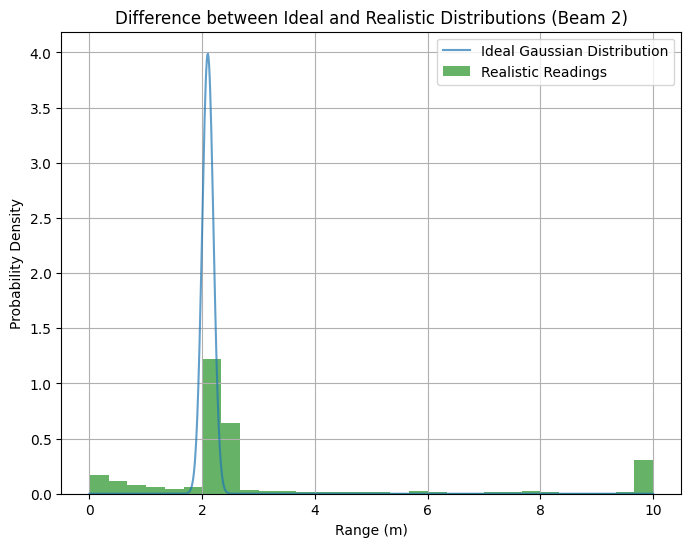

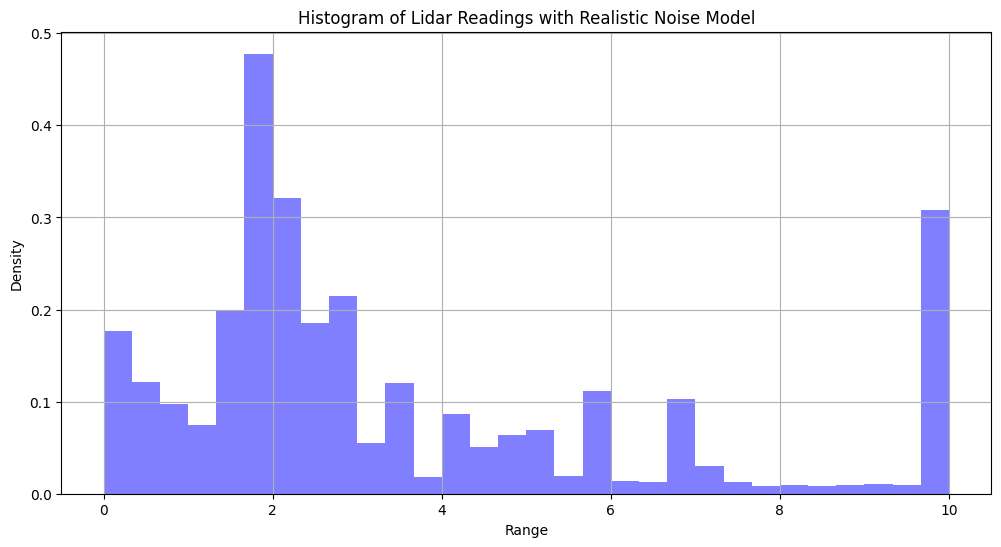

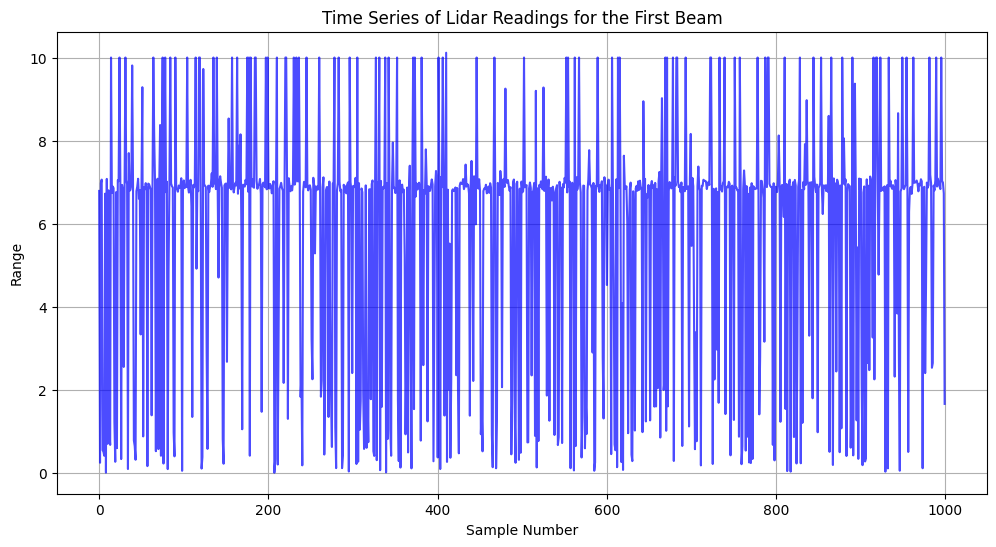

In [11]:
np.random.seed(0)
env.reset()
sensor = Lidar2DRealistic(env.map)
beam_index = 1
num_samples = 1000  # Use a larger number of samples for a better empirical distribution
initial_state = np.array([-2.5, -2, np.pi/2])

# Collect data for a specific beam
ranges = [sensor.step(initial_state)["ranges"][beam_index] for _ in range(num_samples)]

# Calculate the mean and standard deviation for the Gaussian distribution
z_true = sensor.step(initial_state)["ranges"][beam_index]  # Get the true range value for the beam
std = sensor.sigma_hit  # Use the actual standard deviation from the sensor model

# Generate a probability density function based on the z_true and std
dist = np.linspace(0, sensor.z_max, 1000)
ideal_prob = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((dist - z_true) / std) ** 2)

# Plot the ideal Gaussian distribution
plt.figure(figsize=(8, 6))
plt.plot(dist, ideal_prob, alpha=0.7, label="Ideal Gaussian Distribution")

# Plot the histogram of the noisy readings
count, bins, ignored = plt.hist(ranges, bins=30, density=True, alpha=0.6, color='g', label="Realistic Readings")

plt.xlabel("Range (m)")
plt.ylabel("Probability Density")
plt.title(f"Difference between Ideal and Realistic Distributions (Beam {beam_index + 1})")
plt.legend()
plt.grid(True)
plt.show()

# Utilize the show_plots functionality
readings = []
for _ in range(num_samples):
    data = sensor.step(initial_state)
    readings.extend(data['ranges'])

# Plot the histogram of LiDAR readings
plt.figure(figsize=(12, 6))
plt.hist(readings, bins=30, density=True, alpha=0.5, color='blue')
plt.title('Histogram of Lidar Readings with Realistic Noise Model')
plt.xlabel('Range')
plt.ylabel('Density')
plt.grid()
plt.show()

# Plot the time series for the first beam
time_series = [sensor.step(initial_state)['ranges'][0] for _ in range(num_samples)]
plt.figure(figsize=(12, 6))
plt.plot(time_series, 'b-', alpha=0.7)
plt.title('Time Series of Lidar Readings for the First Beam')
plt.xlabel('Sample Number')
plt.ylabel('Range')
plt.grid(True)
plt.show()


# Problem 2: Coordinate Transformations

There are 8 pairs of coordinate frames below.
For each pair, estimate the transformation matrix, $T_{BS} \in SE(3)$ ($B$ = "big" and $S$ = "small"). We will use the convention that red = x, green = y, blue = z (RGB <-> XYZ).

You can also find a [.gif](https://northeastern.sharepoint.com/:f:/s/EECE5550Crew/ElF9gpamBx5Ph-hgX-RKkxoBZECGhaPnDAEW5_4rIy-gvQ?e=GyZm4r) for each coordinate frame pair to get better views than the static images below.

Since there are no gridlines for dimensions, you can provide your best estimate "by hand". In other words, you **shouldn't need any formulas** and it's ok if your numbers aren't exactly right. To give a rough idea of scale, the big coordinate axes are each of length 2 and the small coordinate axes are each of length 1. The rotations all use multiples of $\frac{\pi}{4}$, and the translations all use multiples of 0.5.

Finally, you should not include any scaling coefficients in your matrix (we only scaled the axes to make it clear that there were 2 different frames).

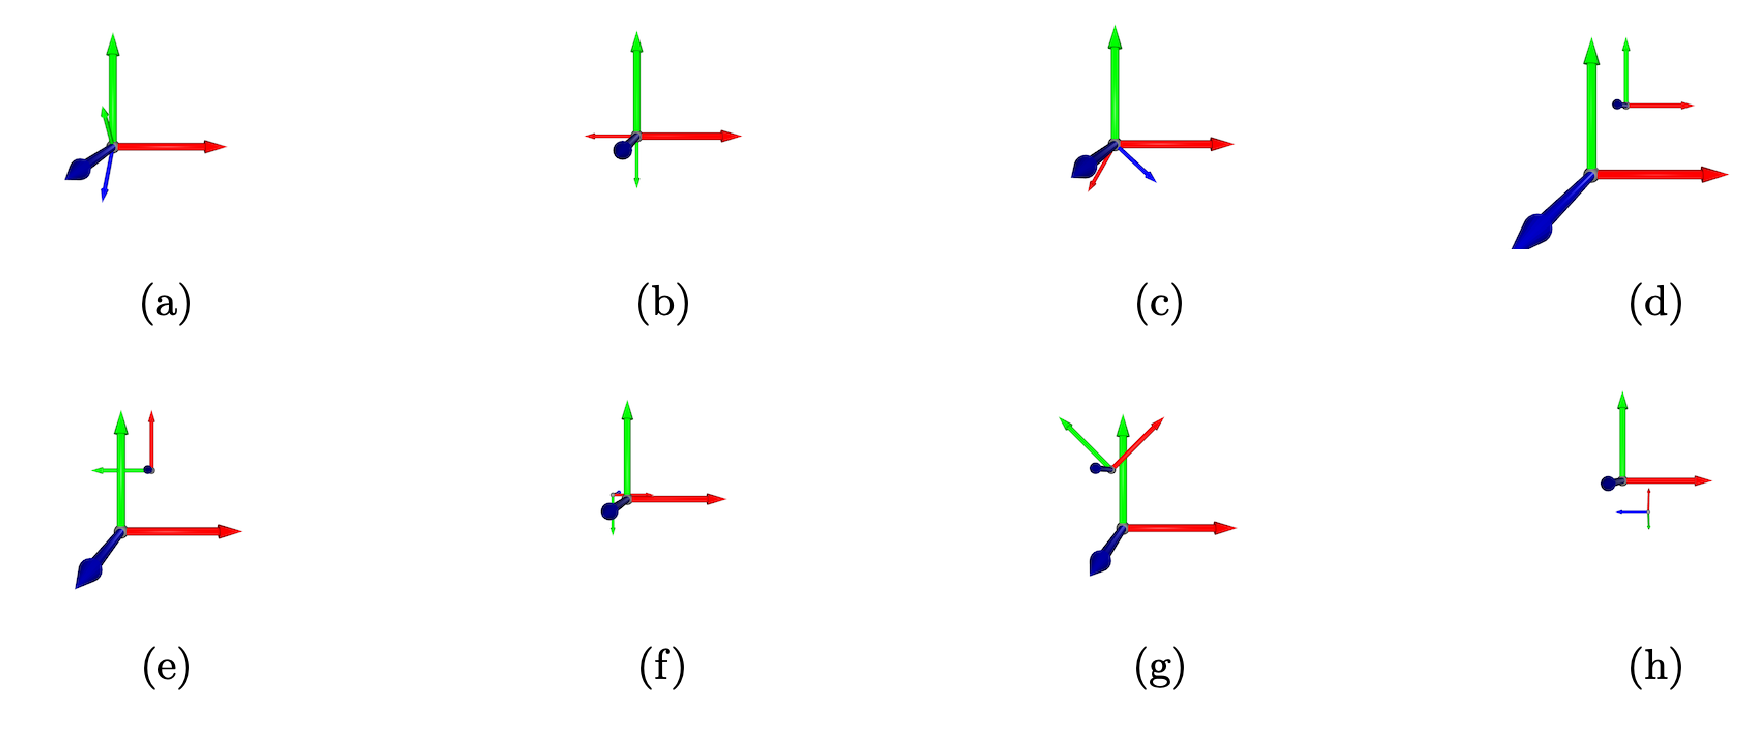

In [12]:
def T_BS_part_a() -> np.ndarray:
    T_BS = np.array([
        [1,     0,      0,     0],
        [0,  0.7071, -0.7071,  0],
        [0,  0.7071,  0.7071,  0],
        [0,     0,      0,     1]
    ])
    return T_BS

def T_BS_part_b() -> np.ndarray:
    T_BS = np.array([
        [-1,  0,  0,  0],
        [ 0, -1,  0,  0],
        [ 0,  0,  1,  0],
        [ 0,  0,  0,  1]
    ])
    return T_BS

def T_BS_part_c() -> np.ndarray:
    T_BS = np.array([
        [-0.5,    0.5,    0.7071, 0],
        [-0.8536, -0.1464, -0.5,   0],
        [-0.1464, -0.8536, 0.5,    0],
        [0,       0,       0,      1]
    ])
    return T_BS

def T_BS_part_d() -> np.ndarray:
    T_BS = np.array([
        [1, 0, 0, 0.5],
        [0, 1, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    return T_BS

def T_BS_part_e() -> np.ndarray:
    T_BS = np.array([
        [0,  -1, 0, 0.5],
        [1,   0, 0, 1],
        [0,   0, 1, 0],
        [0,   0, 0, 1]
    ])
    return T_BS

def T_BS_part_f() -> np.ndarray:
    T_BS = np.array([
        [1,     0,      0,     -0.5],
        [0,    -1,      0,      0],
        [0,     0,     -1,     -1],
        [0,     0,      0,      1]
    ])
    return T_BS

def T_BS_part_g() -> np.ndarray:
    T_BS = np.array([
     [ 0.7071, -0.7071, 0,      0],
     [ 0.7071,  0.7071, 0,      1],
     [ 0,       0,      1,      1],
     [ 0,       0,      0,      1]
     ])
    return T_BS

def T_BS_part_h() -> np.ndarray:
    T_BS = np.array([
        [0,       0,      -1,     0.5],
        [0.7071, -0.7071,  0,     -1],
        [-0.7071, -0.7071, 0,     -2],
        [0,       0,       0,      1]
    ])
    return T_BS

# Problem 3: Object pose estimation

A 3D object $O$ has feature points at the following locations, expressed in the object's body-centric coordinate frame: ${}_O p_1, {}_O p_2, {}_O p_3, {}_O p_4 \in \mathbb{R}^3$.

Using a stereo camera (or 3D lidar), a robot observes this object, and measures the locations of these feature points as ${}_S p_1, {}_S p_2, {}_S p_3, {}_S p_4 \in \mathbb{R}^3$ in the stereo camera's body-centric frame $S$.

What is the pose $T_{SO} \in SE(3)$ of object $O$ with respect to the camera frame $S$? In this problem, you will write a function that can compute this pose, assuming the given points have properties that make this possible.

**Deliverables**:
- Implement `estimate_pose_from_feature_pts` to return $T_{SO} \in SE(3)$ as a np.array of size (4,4)
- Write a 1-2 sentence description of what property(ies) the given points need to have that make solving for this pose possible.

In [13]:
def estimate_pose_from_feature_pts(op1, op2, op3, op4, sp1, sp2, sp3, sp4):
    O_p = np.array([op1, op2, op3, op4]).T  
    S_p = np.array([sp1, sp2, sp3, sp4]).T  

    # 1. Calculate centroids
    O_centroid = O_p.mean(axis=1, keepdims=True)
    S_centroid = S_p.mean(axis=1, keepdims=True)

    # 2. Center the points around the origin
    O_p_centered = O_p - O_centroid
    S_p_centered = S_p - S_centroid

    # 3. Compute the covariance matrix and then the rotation matrix
    H = O_p_centered @ S_p_centered.T
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:  
        Vt[2, :] *= -1
        R = Vt.T @ U.T

    # 4. Compute the translation vector
    t = S_centroid - R @ O_centroid
    # 4. Compute the translation vector
    #t = S_centroid - R @ O_centroid[:3]  # Ensure O_centroid is a 3x1 vector
 
    

    # 5. Construct the transformation matrix T_SO
    T_SO = np.eye(4)
    T_SO[:3, :3] = R
    T_SO[:3, 3] = t.flatten()

    return T_SO

You can debug your code with the following example points (we'll use different points to check your implementation):

In [14]:
# Feature pts in O
op1 = np.array([2, 3, -3])
op2 = np.array([0, 0, -3])
op3 = np.array([-1, -2, 2])
op4 = np.array([-1, 0, 2])

# Feature pts in S
sp1 = np.array([1.8641, 3.0182, -0.5214])
sp2 = np.array([-0.0960, -0.0064, -0.4255])
sp3 = np.array([-0.0827, -2.5055, 4.4484])
sp4 = np.array([-0.0827, -0.5155, 4.6480])

T_SO = estimate_pose_from_feature_pts(op1, op2, op3, op4, sp1, sp2, sp3, sp4)
print(T_SO)

# Check that the estimate of sp1 by transforming op1 is the same as the true sp1
sp1_estimated = T_SO@np.hstack([op1, 1])
np.testing.assert_array_almost_equal(sp1_estimated[:3], sp1)
#np.testing.assert_array_almost_equal(sp1_estimated[:3], sp1, decimal=4) 
# when I am using the above line of code I am able to solve the below error.

[[ 9.80064676e-01  3.50704477e-06  1.98678714e-01  5.00013480e-01]
 [ 1.98307267e-02  9.95004482e-01 -9.78407999e-02 -2.99971521e-01]
 [-1.97686554e-01  9.98302551e-02  9.75168676e-01  2.50000177e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 3 / 3 (100%)
Max absolute difference: 2.57800238e-05
Max relative difference: 2.57078027e-05
 x: array([ 1.864117,  3.018226, -0.521387])
 y: array([ 1.8641,  3.0182, -0.5214])